In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


In [5]:
data_dir = '/home/gourav/Downloads/hymenoptera_data'

In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)
print(dataset_sizes)

['ants', 'bees']
{'train': 244, 'val': 153}


In [12]:
inputs, classes = next(iter(dataloaders['train']))

In [13]:
print(classes)

tensor([0, 0, 1, 0])


In [15]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

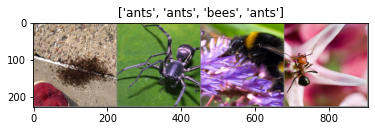

In [16]:
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

    
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

               
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [18]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/gourav/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100.0%


In [19]:
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [21]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6171 Acc: 0.6557
val Loss: 0.4146 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4786 Acc: 0.8115
val Loss: 0.3314 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4885 Acc: 0.7500
val Loss: 0.2869 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4450 Acc: 0.7787
val Loss: 0.2347 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4724 Acc: 0.7951
val Loss: 0.2290 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3643 Acc: 0.8443
val Loss: 0.1974 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3944 Acc: 0.8238
val Loss: 0.1951 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3828 Acc: 0.8238
val Loss: 0.1946 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3435 Acc: 0.8443
val Loss: 0.2092 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3284 Acc: 0.8648
val Loss: 0.2108 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3613 Acc: 0.8361
val Loss: 0.2206 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3923 Acc: 0.8074
val Loss: 0.1932 Acc: 0.9477

Ep

In [22]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [23]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [24]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [25]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [26]:

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7031 Acc: 0.5943
val Loss: 0.3621 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.4801 Acc: 0.7582
val Loss: 0.5203 Acc: 0.7908

Epoch 2/24
----------
train Loss: 0.4766 Acc: 0.7869
val Loss: 0.2534 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4920 Acc: 0.7910
val Loss: 0.1953 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4213 Acc: 0.8238
val Loss: 0.1831 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4464 Acc: 0.7787
val Loss: 0.2733 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.2890 Acc: 0.8525
val Loss: 0.1883 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4091 Acc: 0.8238
val Loss: 0.1974 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3198 Acc: 0.8402
val Loss: 0.2015 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2924 Acc: 0.9057
val Loss: 0.1803 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3192 Acc: 0.8361
val Loss: 0.1782 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3188 Acc: 0.8484
val Loss: 0.1760 Acc: 0.9477

Ep